In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load dataset
dataset = pd.read_csv("./data/Synthetic_Data_For_Students.csv")

In [3]:

# Labels
redundant_labels = ['AccidentType', 'Accident Description', 'Claim Date', 'Accident Date',
                    'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest',
                    'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications',
                    'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift',
                    'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy',
                    'Dominant injury']

category_labels = ['Exceptional_Circumstances', 'Minor_Psychological_Injury',
                   'Whiplash', 'Vehicle Type', 'Weather Conditions',
                   'Police Report Filed', 'Witness Present', 'Gender', 'Injury Description']

numerical_labels = ['SettlementValue', 'Injury_Prognosis',
                    'Vehicle Age', 'Driver Age', 'Number of Passengers']


In [4]:
# Data Cleaning & Preprocessing
def clean_dataset(data):
    data.dropna(inplace=True)
    data.drop(redundant_labels, axis=1, inplace=True)
    return data

def categorise_data(data, label):
    values = data[label].astype(str).str.lower()
    if values.nunique() == 2 and set(values.unique()) <= {'yes', 'no'}:
        data[label] = values.map({'yes': True, 'no': False})
    elif values.nunique() <= 5:
        data[label], _ = pd.factorize(data[label])
    else:
        categories = pd.get_dummies(data[label], prefix=label)
        data.drop(label, axis=1, inplace=True)
        data = pd.concat([data, categories], axis=1)
    return data

def extract_months(prognosis):
    return int(''.join(filter(str.isdigit, str(prognosis))))

def scale_data(data):
    scaler = MinMaxScaler()
    data[numerical_labels] = scaler.fit_transform(data[numerical_labels])
    return data, scaler

def preprocess_data(data):
    data = clean_dataset(data)
    data['Injury_Prognosis'] = data['Injury_Prognosis'].apply(extract_months)
    upper_limit = data['SettlementValue'].quantile(0.95)
    lower_limit = data['SettlementValue'].quantile(0.05)
    data = data[(data['SettlementValue'] <= upper_limit) & (data['SettlementValue'] >= lower_limit)]
    data, scaler = scale_data(data)
    for label in category_labels:
        data = categorise_data(data, label)
    return data, scaler

# Apply preprocessing
df, scaler = preprocess_data(dataset)


/tmp/ipykernel_229/2428606221.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numerical_labels] = scaler.fit_transform(data[numerical_labels])
/tmp/ipykernel_229/2428606221.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[label] = values.map({'yes': True, 'no': False})
/tmp/ipykernel_229/2428606221.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [5]:

# Split data
X = df.drop(columns=['SettlementValue'])
y = df['SettlementValue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:

# Random Forest with GridSearch
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# Gradient Boosting with RandomSearch
gbr = GradientBoostingRegressor()
param_dist = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0]
}
random_search = RandomizedSearchCV(
    gbr, param_distributions=param_dist, n_iter=20, cv=3,
    scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)
gbr_best = random_search.best_estimator_

# Stacking Regressor
base_learners = [
    ('lr', LinearRegression()),
    ('rf', rf_best),
    ('gbr', gbr_best)
]
meta_model = Ridge(alpha=1.0)
stacking_model = StackingRegressor(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [7]:

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n--- Stacking Regressor Evaluation ---")
print(f"Mean Absolute Error (MAE): £{mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



--- Stacking Regressor Evaluation ---
Mean Absolute Error (MAE): £0.15
Root Mean Squared Error (RMSE): 0.19
R² Score: 0.2463
Mean Absolute Percentage Error (MAPE): inf%


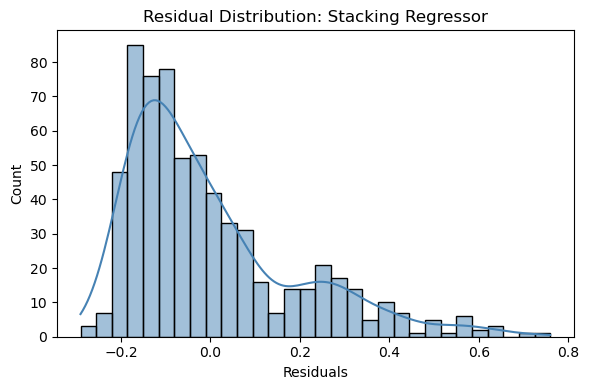

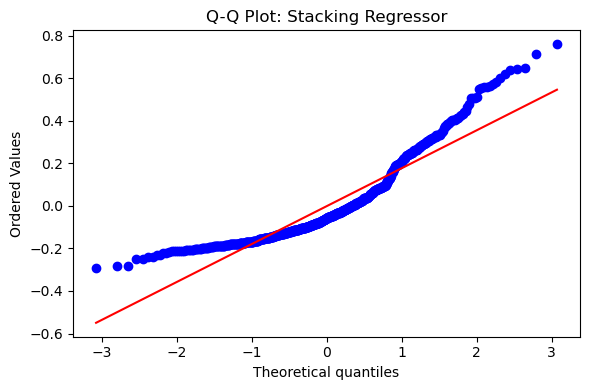

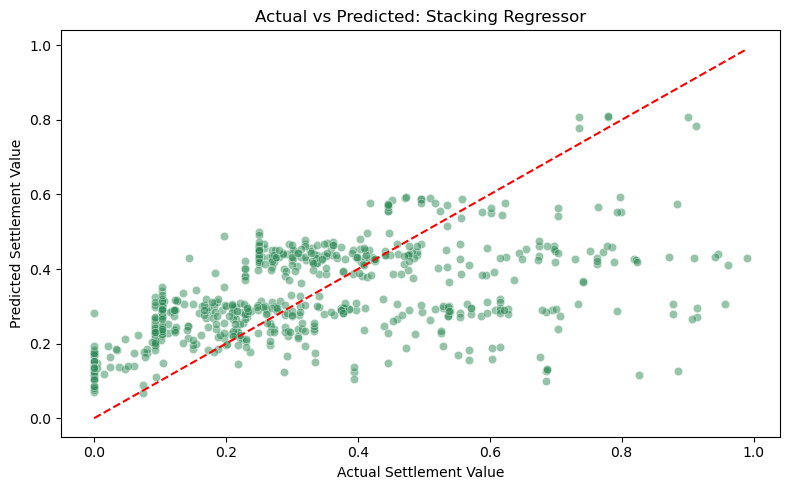

In [8]:

# Plots
residuals = y_test - y_pred

# Residual distribution
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30, color="steelblue")
plt.title("Residual Distribution: Stacking Regressor")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot: Stacking Regressor")
plt.tight_layout()
plt.show()

# Actual vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='seagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Settlement Value")
plt.ylabel("Predicted Settlement Value")
plt.title("Actual vs Predicted: Stacking Regressor")
plt.tight_layout()
plt.show()
